# Cylindrical compressive test

In [1]:
from ibvpy.bcond import BCSlice
from ibvpy.fets import FETS3D8H
from ibvpy.tmodel.mats3D import MATS3DElastic
from bmcs_matmod.ms1.ms1 import MS13D
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from mayavi import mlab
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid

import numpy as np

In [2]:
from bmcs_expsim.utils.mlab_decorators import decorate_figure

**Check the material parameters** of C40 concrete matrix

In [3]:
mp_db.C40MS1

{'E': 37000.0,
 'nu': 0.2,
 'Ad': 800.0,
 'eps_0': 7e-05,
 'K_N': 14000.0,
 'sigma_N_0': 25.0,
 'gamma_N': 5000.0,
 'sigma_T_0': 2.2,
 'K_T': 1200.0,
 'gamma_T': 65000,
 'S_T': 0.0025,
 'c_T': 8.7,
 'r_T': 9.2,
 'm_T': 0.001,
 'p_T': 7.5}

In [7]:
xmodel = XDomainFEGrid(coord_min=(0,0,0),
                     coord_max=(1,1, 1),
                     shape=(1, 1, 1),
                     integ_factor=1,
                     fets=FETS3D8H())

In [8]:
tmodel = MS13D(**mp_db.C40MS1)
#tmodel = MATS3DElastic(E=1, nu=0)

In [9]:
w_max = -1e-2
#w_max = -1
bc_l_x = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                  var='u', dims=[0], value=0.0)
bc_r_x = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=w_max)
bc_xy_z0 = BCSlice(slice=xmodel.mesh[:, :, 0, :, :, 0],
                  var='u', dims=[2], value=0)
bc_xz_y0 = BCSlice(slice=xmodel.mesh[:, 0, :, :, 0, :],
                 var='u', dims=[1], value=0)


In [10]:
m = TStepBC(
    domains=[(xmodel, tmodel)],
    bc=[bc_l_x, bc_r_x, bc_xy_z0, bc_xz_y0] # , bc_r_y],
)

m.hist.vis_record = {
    'strain': Vis3DTensorField(var='eps_ab'),
    # 'stress': Vis3DTensorField(var='sig_ab'),
    #        'damage': Vis3DStateField(var='omega_a'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}


In [11]:
w_steps = 20
s = m.sim
s.tloop.k_max = 1000
s.tline.step = 1 / w_steps
s.tloop.verbose = True
s.run()

VAR
eps_ab
DOMAIN
{'eps_ab': <bound method MATSXDEval.get_eps_ab of <bmcs_matmod.ms1.ms1.MS13D object at 0x7f02db296090>>, 'sig_ab': <bound method MATSXDEval.get_sig_ab of <bmcs_matmod.ms1.ms1.MS13D object at 0x7f02db296090>>}
t:	 0.00(0), 
	 0.05(3), 
	 0.10(6), 
	 0.15(8), 
	 0.20(8), 
	 0.25(23), 
	 0.30(11), 
	 0.35(16), 
	 0.40(14), 
	 0.45(20), 
	 0.50(17), 
	 0.55(9), 
	 0.60(8), 
	 0.65(9), 
	 0.70(7), 
	 0.75(9), 
	 0.80(9), 
	 0.85(10), 
	 0.90(10), 
	 0.95(11), 
	 1.00(11), 



In [12]:
F_to = m.hist.F_t
U_to = m.hist.U_t

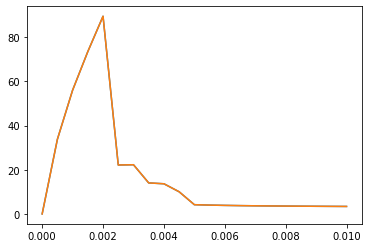

In [13]:
F_l_t = np.sum(F_to[:, bc_l_x.dofs], axis=-1)
F_r_t = np.sum(F_to[:, bc_r_x.dofs], axis=-1)
U_r_t = np.average(U_to[:, bc_r_x.dofs], axis=-1)

import matplotlib.pylab as plt
plt.plot(-U_r_t, -F_r_t)
plt.plot(-U_r_t, F_l_t)